In [1]:
# Importing necessary libraries.

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve,auc, confusion_matrix

In [2]:
# Loading the dataset

df_spam = pd.read_csv("messages.csv")
df_spam

subject  \
0               job posting - apple-iss research center   
1                                                   NaN   
2     query : letter frequencies for text identifica...   
3                                                  risk   
4                              request book information   
...                                                 ...   
2888                       love your profile - ysuolvpv   
2889                 you have been asked to join kiddin   
2890                 anglicization of composers ' names   
2891  re : 6 . 797 , comparative method : n - ary co...   
2892               re : american - english in australia   

                                                message  label  
0     content - length : 3386 apple-iss research cen...      0  
1     lang classification grimes , joseph e . and ba...      0  
2     i am posting this inquiry for sergei atamas ( ...      0  
3     a colleague and i are researching the differin...      0  
4     earlier this morning i was on the phone with a...      0  
...                                                 ...    ...  
2888  hello thanks for stopping by ! ! we have taken...      1  
2889  the list owner of : " kiddin " has invited you...      1  
2890  judging from the return post , i must have sou...      0  
2891  gotcha ! there are two separate fallacies in t...      0  
2892  hello ! i ' m working on a thesis concerning a...      0  

[2893 rows x 3 columns]

In [3]:
# Shape of the dataset
df_spam.shape

(2893, 3)

In [4]:
# Checking the datatypes of each column
df_spam.dtypes

subject    object
message    object
label       int64
dtype: object

The text body i.e. the 'subject' and 'message' columns are of objet type. Thus changing the datatype into string.

In [5]:
# Convert the datatpe into string.

df_spam['subject'] = df_spam['subject'].apply(lambda x : str(x))
df_spam['message'] = df_spam['message'].apply(lambda x : str(x))

subject    0
message    0
label      0
dtype: int64


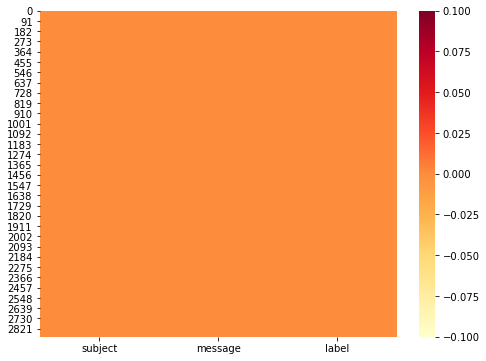

In [6]:
# Checking the null values and visualizing the same using heatmap.
print(df_spam.isnull().sum())

plt.figure(figsize=(8,6))
sns.heatmap(df_spam.isnull(), cmap = 'YlOrRd')
plt.show()

There are no null values in this dataset.

In [7]:
# Merging both the columns i.e. 'subject' and 'message' to form one column only named 'email'.

df_spam['email'] = df_spam['subject'] + " " + df_spam['message']
df_spam.head()

subject  \
0            job posting - apple-iss research center   
1                                                nan   
2  query : letter frequencies for text identifica...   
3                                               risk   
4                           request book information   

                                             message  label  \
0  content - length : 3386 apple-iss research cen...      0   
1  lang classification grimes , joseph e . and ba...      0   
2  i am posting this inquiry for sergei atamas ( ...      0   
3  a colleague and i are researching the differin...      0   
4  earlier this morning i was on the phone with a...      0   

                                               email  
0  job posting - apple-iss research center conten...  
1  nan lang classification grimes , joseph e . an...  
2  query : letter frequencies for text identifica...  
3  risk a colleague and i are researching the dif...  
4  request book information earlier this morning ...

In [8]:
# Now, just dropping the original 'subject' and ' message' columns.
df_spam.drop(['subject', 'message'], axis = 1, inplace = True)
df_spam.head(3)

label                                              email
0      0  job posting - apple-iss research center conten...
1      0  nan lang classification grimes , joseph e . an...
2      0  query : letter frequencies for text identifica...

In [9]:
# Shape of the new dataset.
df_spam.shape

(2893, 2)

So, now the datset contains only 2 columns named 'email' and 'label' having 2894 rows in total.

Ham and Spam Counts which are represented by 0 and 1 respectively : 
 0    2412
1     481
Name: label, dtype: int64 

Spam ratio :  17.0 %
Ham ratio :  83.0 % 



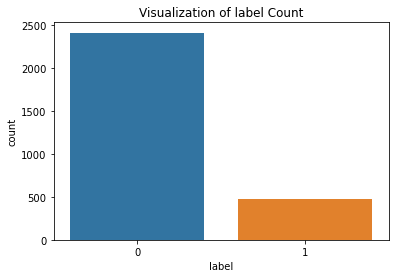

In [10]:
# Cheking the value counts of the target variable 'label' and visualizing the same using countplot.
print("Ham and Spam Counts which are represented by 0 and 1 respectively : \n", df_spam['label'].value_counts(), "\n")

print("Spam ratio : ", round(len(df_spam[df_spam['label'] == 1]) / len(df_spam.label),2)*100, '%')
print("Ham ratio : ", round(len(df_spam[df_spam['label'] == 0]) / len(df_spam.label),2)*100, '% \n')

sns.countplot(df_spam['label'], data=df_spam)
plt.title("Visualization of label Count")
plt.show()

The target variable is imbalanced, where spam is just 17% of tottal data as compared to the ham emails.

In [11]:
# statistical summary
df_spam.describe()

label
count  2893.000000
mean      0.166263
std       0.372381
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000

In [12]:
df_spam['length'] = df_spam['email'].map(lambda email: len(email))
df_spam

label                                              email  length
0         0  job posting - apple-iss research center conten...    2896
1         0  nan lang classification grimes , joseph e . an...    1804
2         0  query : letter frequencies for text identifica...    1486
3         0  risk a colleague and i are researching the dif...     329
4         0  request book information earlier this morning ...    1071
...     ...                                                ...     ...
2888      1  love your profile - ysuolvpv hello thanks for ...     291
2889      1  you have been asked to join kiddin the list ow...    2198
2890      0  anglicization of composers ' names judging fro...    1074
2891      0  re : 6 . 797 , comparative method : n - ary co...    3004
2892      0  re : american - english in australia hello ! i...     737

[2893 rows x 3 columns]

In [13]:
# Converting the data into lower case.
df_spam['email'] = df_spam['email'].str.lower()

In [14]:
# Creating a function for converting the data into lower case, removig special characters, numbers and punctuations, 
# removing stopwords, Tokenizing the data and lemmatizing the same.

wordnet_lemmatizer = WordNetLemmatizer()
stpwrds = stopwords.words('english')

def remove(text):
    text = re.sub(r'[0-9]', " ", text)
    text = re.sub('[^A-Za-z0-9]+', " ", text)
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_text = tokenizer.tokenize(text)
    removed_stop_text = [wordnet_lemmatizer.lemmatize(word) for word in tokenized_text if word not in stpwrds]
    return " ".join(removed_stop_text)

In [15]:
# Calling the above function for the column - email.

df_spam['email'] = df_spam['email'].apply(remove)
df_spam['email']

0       job posting apple i research center content le...
1       nan lang classification grime joseph e barbara...
2       query letter frequency text identification pos...
3       risk colleague researching differing degree ri...
4       request book information earlier morning phone...
                              ...                        
2888    love profile ysuolvpv hello thanks stopping ta...
2889    asked join kiddin list owner kiddin invited jo...
2890    anglicization composer name judging return pos...
2891    comparative method n ary comparison gotcha two...
2892    american english australia hello working thesi...
Name: email, Length: 2893, dtype: object

In [16]:
df_spam['len_after_cleaning'] = df_spam['email'].map(lambda email: len(email))
df_spam

label                                              email  length  \
0         0  job posting apple i research center content le...    2896   
1         0  nan lang classification grime joseph e barbara...    1804   
2         0  query letter frequency text identification pos...    1486   
3         0  risk colleague researching differing degree ri...     329   
4         0  request book information earlier morning phone...    1071   
...     ...                                                ...     ...   
2888      1  love profile ysuolvpv hello thanks stopping ta...     291   
2889      1  asked join kiddin list owner kiddin invited jo...    2198   
2890      0  anglicization composer name judging return pos...    1074   
2891      0  comparative method n ary comparison gotcha two...    3004   
2892      0  american english australia hello working thesi...     737   

      len_after_cleaning  
0                   1961  
1                   1276  
2                    967  
3                    212  
4                    653  
...                  ...  
2888                 152  
2889                1204  
2890                 654  
2891                1680  
2892                 430  

[2893 rows x 4 columns]

In [17]:
# Now just dropping the 'length' and 'len_after_cleaning' columns and thus having the final dataframe.
df_spam.drop(['length', 'len_after_cleaning'], axis = 1, inplace = True)
df_spam

label                                              email
0         0  job posting apple i research center content le...
1         0  nan lang classification grime joseph e barbara...
2         0  query letter frequency text identification pos...
3         0  risk colleague researching differing degree ri...
4         0  request book information earlier morning phone...
...     ...                                                ...
2888      1  love profile ysuolvpv hello thanks stopping ta...
2889      1  asked join kiddin list owner kiddin invited jo...
2890      0  anglicization composer name judging return pos...
2891      0  comparative method n ary comparison gotcha two...
2892      0  american english australia hello working thesi...

[2893 rows x 2 columns]

In [18]:
# Feature extraction
# Convert a collection of text i.e. df_spam['email'] to a matriz of token.

tf_vec = TfidfVectorizer(analyzer=remove)
features = tf_vec.fit_transform(df_spam['email'])

In [19]:
# Separating the input and target variables

X = features
y = df_spam[["label"]]

In [20]:
X

<2893x27 sparse matrix of type '<class 'numpy.float64'>'
	with 74377 stored elements in Compressed Sparse Row format>

In [25]:
# Splitting the training and testing data and finding the maximum accuracy score at best random state.
def train_test (clf ,X, y):
    max_acc_scr = 0
    for r_state in range(42,101):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = r_state)
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        acc_scr = accuracy_score(pred, y_test)
        if acc_scr > max_acc_scr:
            max_acc_scr = acc_scr
            final_r_state = r_state
    
    print("Maximum Accuracy score is :", max_acc_scr, "achieved at :", final_r_state)
    print("\n")
    print("Classification Report :\n", classification_report(pred, y_test))
    print("\n")
    cm = confusion_matrix(pred, y_test)
    print("Confusion Matrix :\n", cm)
    print("\n")       
    false_positive_rate, true_positive_rate, threshold = roc_curve(pred, y_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print("ROC_AUC_CURVE :", roc_auc)
    print("\n")

In [36]:
# Creating the instances for the algorithms.

lr = LogisticRegression()
gnb = GaussianNB()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier()
knc = KNeighborsClassifier()
rfc = RandomForestClassifier()

In [27]:
models = []
models.append(('LogisticRegression', lr))
models.append(('GaussianNB', gnb))
models.append(('MultinomialNB', mnb))
models.append(('DecisionTreeClassifier', dtc))
models.append(('KNeighborsClassifier', knc))
models.append(('RandomForestClassifier', rfc))

In [28]:
# Creating a list which holds the algorithms.

model = []
cvs = []

for name,model in models:
    k=model
    print('--------',name,'--------')
    r_state = train_test(k, X.toarray(), y)
    print('\n')
    cross_val = cross_val_score(k, X.toarray(), y, cv=5, scoring = "accuracy").mean()
    print('Cross validation score (Mean r2 score):', cross_val)
    std_score = cross_val_score(k, X.toarray(), y, cv=5, scoring = "accuracy").std()
    print('Standard Deviationin r2 score :', std_score)
    print('\n')
    print('\n')

-------- LogisticRegression --------
Maximum Accuracy score is : 0.8963730569948186 achieved at : 43


Classification Report :
               precision    recall  f1-score   support

           0       0.99      0.85      0.92       557
           1       0.19      0.86      0.31        22

    accuracy                           0.85       579
   macro avg       0.59      0.86      0.61       579
weighted avg       0.96      0.85      0.89       579



Confusion Matrix :
 [[475  82]
 [  3  19]]


ROC_AUC_CURVE : 0.8582095642239269




Cross validation score (Mean r2 score): 0.8589753243571124
Standard Deviationin r2 score : 0.007907013826927422




-------- GaussianNB --------
Maximum Accuracy score is : 0.9067357512953368 achieved at : 69


Classification Report :
               precision    recall  f1-score   support

           0       0.92      0.91      0.91       486
           1       0.55      0.60      0.58        93

    accuracy                           0.86       579
   ma

In [35]:
# predicting the model.

def find(x):
    if x == 1:
        print ("Message is SPAM")
    else:
        print ("Message is NOT Spam")
text = ["This ProJect is completed!"]
integers = tf_vec.transform(text)
x = rfc.predict(integers)[0]
find(x) 

Message is SPAM
